In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [2]:
df = pd.read_csv("cleaned_5yr_stock_data_with_month.csv", parse_dates=["Date"])
df.head()


,Date,Open,High,Low,Close,Volume,Ticker,momentum_rsi,trend_macd,volatility_bbm,trend_ema_fast,Daily_Return,Month
0,2019-02-07,41.07,41.43,40.58,40.72,126966800,AAPL,66.47,1.08,38.04,39.48,NaN,2019-02
1,2019-02-08,40.43,40.83,40.29,40.77,95280000,AAPL,66.69,1.10,38.25,39.67,0.12,2019-02
2,2019-02-11,40.92,40.96,40.49,40.53,83973600,AAPL,64.44,1.09,38.46,39.81,-0.58,2019-02
3,2019-02-12,40.69,40.91,40.60,40.88,89134000,AAPL,66.27,1.09,38.72,39.97,0.86,2019-02
4,2019-02-13,41.00,41.26,40.65,40.71,89960800,AAPL,64.53,1.07,38.93,40.09,-0.42,2019-02


In [3]:
df.shape

(15880, 13)

In [4]:
# Ternary classification: Negative, Neutral, Positive
df['Return_Level'] = pd.qcut(df['Daily_Return'], q=3, labels=[0, 1, 2])


In [5]:
df['Price_Change'] = df['Close'] - df['Open']
df['High_Low_Spread'] = df['High'] - df['Low']
df['Volatility_Adjusted_Return'] = df['Daily_Return'] / (df['volatility_bbm'] + 1e-6)


In [6]:
df['Return_Level'] = pd.qcut(df['Daily_Return'], q=3, labels=[0, 1, 2])
df = df.dropna(subset=['Return_Level'])  # Drop rows with NaN in the target
df['Return_Level'] = df['Return_Level'].astype(int)  # Ensure it's integer for modeling


In [8]:
# Features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'momentum_rsi',
            'trend_macd', 'volatility_bbm', 'trend_ema_fast']
target = 'Return_Level'

X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


In [9]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train & evaluate
results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f'🔎 {name} Classification Report:\n')
    print(classification_report(y_test, y_pred))
    results[name] = confusion_matrix(y_test, y_pred)


🔎 Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.67      0.67      1330
           1       0.55      0.64      0.59      1324
           2       0.72      0.59      0.65      1314

    accuracy                           0.64      3968
   macro avg       0.65      0.64      0.64      3968
weighted avg       0.65      0.64      0.64      3968

🔎 Decision Tree Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.49      0.49      1330
           1       0.39      0.41      0.40      1324
           2       0.44      0.43      0.43      1314

    accuracy                           0.44      3968
   macro avg       0.44      0.44      0.44      3968
weighted avg       0.44      0.44      0.44      3968

🔎 Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.57      0.59      0.58      1330
   

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)


{'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}


In [11]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print("🔎 XGBoost Classification Report:\n")
print(classification_report(y_test, y_pred_xgb))


/opt/homebrew/Cellar/jupyterlab/4.3.6/libexec/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [19:20:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔎 XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.65      0.69      0.67      1330
           1       0.54      0.52      0.53      1324
           2       0.63      0.61      0.62      1314

    accuracy                           0.61      3968
   macro avg       0.61      0.61      0.61      3968
weighted avg       0.61      0.61      0.61      3968



In [12]:
# Create new features
df['Price_Change'] = df['Close'] - df['Open']
df['High_Low_Spread'] = df['High'] - df['Low']
df['Volatility'] = (df['High'] - df['Low']) / df['Open']
df['Rolling_Return'] = df.groupby('Ticker')['Daily_Return'].transform(lambda x: x.rolling(window=5).mean())
df['Rolling_Volume'] = df.groupby('Ticker')['Volume'].transform(lambda x: x.rolling(window=5).mean())

# Drop rows with NaN from rolling calculations
df.dropna(inplace=True)


In [13]:
features = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'momentum_rsi', 'trend_macd', 'volatility_bbm', 'trend_ema_fast',
    'Price_Change', 'High_Low_Spread', 'Volatility', 'Rolling_Return', 'Rolling_Volume'
]

# Encode categorical Ticker
df['Ticker_encoded'] = df['Ticker'].astype('category').cat.codes
features.append('Ticker_encoded')

target = 'Return_Level'


In [16]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print("🔎 XGBoost Classification Report:\n")
print(classification_report(y_test, y_pred_xgb))


/opt/homebrew/Cellar/jupyterlab/4.3.6/libexec/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [19:26:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔎 XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1327
           1       0.60      0.59      0.59      1319
           2       0.73      0.74      0.73      1312

    accuracy                           0.69      3958
   macro avg       0.69      0.69      0.69      3958
weighted avg       0.69      0.69      0.69      3958



In [20]:
from sklearn.pipeline import Pipeline
# Load dataset
df = pd.read_csv("cleaned_5yr_stock_data_with_month.csv")

# Drop any missing values
df.dropna(inplace=True)

# Encode ticker
le = LabelEncoder()
df['Ticker_encoded'] = le.fit_transform(df['Ticker'])

# Define features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'momentum_rsi',
            'trend_macd', 'volatility_bbm', 'trend_ema_fast', 'Ticker_encoded']
target = 'Daily_Return'

# Bin Daily_Return into 3 classes
df['Return_Level'] = pd.qcut(df['Daily_Return'], q=3, labels=[0, 1, 2])

X = df[features]
y = df['Return_Level']


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [23]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(eval_metric='mlogloss'))
])

param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__subsample': [0.8, 1],
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)

grid.fit(X_train, y_train)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='mlogloss',
                                                      feature_types=None,
                                                      feature_weights=None,
                                                      gamma=None,
                                                      grow_pol...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__learning_rate': [0.01, 0.1],
                         'xgb__max_depth': [3, 5, 7],
                         'xgb__n_estimators': [100, 200],
                         'xgb__subsample': [0.8, 1]},
             scoring='accuracy', verbose=1)

In [24]:
from sklearn.metrics import classification_report

y_pred = grid.predict(X_test)
print("Best Parameters:", grid.best_params_)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Best Parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}

Classification Report:

              precision    recall  f1-score   support

           0       0.66      0.69      0.67      1063
           1       0.53      0.51      0.52      1059
           2       0.61      0.61      0.61      1052

    accuracy                           0.60      3174
   macro avg       0.60      0.60      0.60      3174
weighted avg       0.60      0.60      0.60      3174



In [25]:
from sklearn.utils.class_weight import compute_sample_weight

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
grid.fit(X_train, y_train, xgb__sample_weight=sample_weights)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='mlogloss',
                                                      feature_types=None,
                                                      feature_weights=None,
                                                      gamma=None,
                                                      grow_pol...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__learning_rate': [0.01, 0.1],
                         'xgb__max_depth': [3, 5, 7],
                         'xgb__n_estimators': [100, 200],
                         'xgb__subsample': [0.8, 1]},
             scoring='accuracy', verbose=1)

In [27]:
df['Open_Close_Spread'] = df['Open'] - df['Close']
df['High_Low_Spread'] = df['High'] - df['Low']
df['Volatility_Adjusted_Return'] = df['Daily_Return'] / (df['volatility_bbm'] + 1e-5)
df['Momentum_Trend_Product'] = df['momentum_rsi'] * df['trend_macd']
df['Volume_Weighted_Return'] = df['Daily_Return'] * df['Volume']


In [28]:
df.drop(['Date', 'Ticker'], axis=1, inplace=True)


In [30]:
df['Open_Close_Spread'] = df['Open'] - df['Close']
df['High_Low_Spread'] = df['High'] - df['Low']
df['Volatility_Adjusted_Return'] = df['Daily_Return'] / (df['volatility_bbm'] + 1e-5)
df['Momentum_Trend_Product'] = df['momentum_rsi'] * df['trend_macd']
df['Volume_Weighted_Return'] = df['Daily_Return'] * df['Volume']



In [31]:
features = [
    'Open', 'High', 'Low', 'Close', 'Volume', 'momentum_rsi',
    'trend_macd', 'volatility_bbm', 'trend_ema_fast', 'Daily_Return',
    'Open_Close_Spread', 'High_Low_Spread', 'Volatility_Adjusted_Return',
    'Momentum_Trend_Product', 'Volume_Weighted_Return'
]

target = 'Return_Level'

X = df[features]
y = df[target]


In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [34]:
from sklearn.metrics import classification_report, accuracy_score

# Predict with the best estimator from grid search
y_pred = grid.predict(X_test)

# Evaluation
print("🔧 Best Parameters:", grid.best_params_)
print("\n📊 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📝 Classification Report:\n", classification_report(y_test, y_pred))


🔧 Best Parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}

📊 Accuracy: 0.9974795211090107

📝 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1063
           1       1.00      1.00      1.00      1059
           2       1.00      1.00      1.00      1052

    accuracy                           1.00      3174
   macro avg       1.00      1.00      1.00      3174
weighted avg       1.00      1.00      1.00      3174



In [35]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

param_grid = {
    'xgb__n_estimators': [200],
    'xgb__max_depth': [7],
    'xgb__learning_rate': [0.1],
    'xgb__subsample': [0.8]
}

grid = GridSearchCV(
    pipeline, param_grid, cv=3, scoring='accuracy',
    verbose=1, n_jobs=-1
)

grid.fit(X_train, y_train)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/homebrew/Cellar/jupyterlab/4.3.6/libexec/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [19:39:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Cellar/jupyterlab/4.3.6/libexec/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [19:39:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Cellar/jupyterlab/4.3.6/libexec/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [19:39:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Cellar/jupyterlab/4.3.6/libexec/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [19:39:28] WARNING: /Users/runner/w

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='mlogloss',
                                                      feature_types=None,
                                                      feature_weights=None,
                                                      gamma=None,
                                                      grow_pol...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__learning_rate': [0.1], 'xgb__max_depth': [7],
                         'xgb__n_estimators': [200], 'xgb__subsample': [0.8]},
             scoring='accuracy', verbose=1)

In [36]:
from sklearn.metrics import classification_report, accuracy_score

# Predict using the best model found by GridSearchCV
y_pred = grid.predict(X_test)

# Print results
print("✅ Best Parameters:", grid.best_params_)
print("🎯 Test Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))


✅ Best Parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}
🎯 Test Accuracy: 0.9974795211090107

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1063
           1       1.00      1.00      1.00      1059
           2       1.00      1.00      1.00      1052

    accuracy                           1.00      3174
   macro avg       1.00      1.00      1.00      3174
weighted avg       1.00      1.00      1.00      3174



In [38]:
from sklearn.model_selection import train_test_split

# Split raw features and target first
X = df.drop(columns=['Return_Level'])  # or whatever your target is
y = df['Return_Level']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Then do feature engineering on X_train and X_test separately
# NOT on the entire df beforehand!


In [40]:
# Remove non-numeric columns
X_train = X_train.select_dtypes(include=['number'])
X_test = X_test.select_dtypes(include=['number'])


In [41]:
grid.fit(X_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Cellar/jupyterlab/4.3.6/libexec/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:29:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Cellar/jupyterlab/4.3.6/libexec/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:29:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Cellar/jupyterlab/4.3.6/libexec/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:29:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Cellar/jupyterlab/4.3.6/libexec/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:29:26] WARNING: /Users/runner/w

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='mlogloss',
                                                      feat...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__learning_rate': [0.1], 'xgb__max_depth': [7],
                         'xgb__n_estimators': [200], 'xgb__subsample': [0.8]},
             scoring='accuracy', verbose=1)

In [42]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = grid.predict(X_test)

print("✅ Best Parameters:", grid.best_params_)
print("🎯 Test Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred))


✅ Best Parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}
🎯 Test Accuracy: 0.9974795211090107

📊 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1063
           1       1.00      1.00      1.00      1059
           2       1.00      1.00      1.00      1052

    accuracy                           1.00      3174
   macro avg       1.00      1.00      1.00      3174
weighted avg       1.00      1.00      1.00      3174



In [43]:
import joblib
joblib.dump(grid.best_estimator_, 'xgb_pipeline_model.pkl')


['xgb_pipeline_model.pkl']

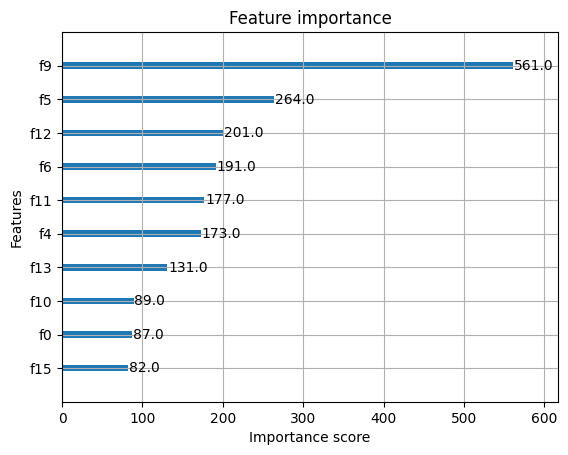

In [44]:
import matplotlib.pyplot as plt
import xgboost as xgb

model = grid.best_estimator_.named_steps['xgb']
xgb.plot_importance(model, max_num_features=10)
plt.show()


In [45]:
import pandas as pd

y_pred = grid.predict(X_test)

preds_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

preds_df.to_csv('test_predictions.csv', index=False)


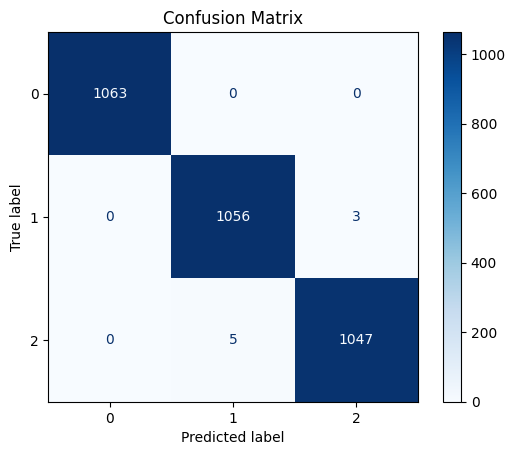

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


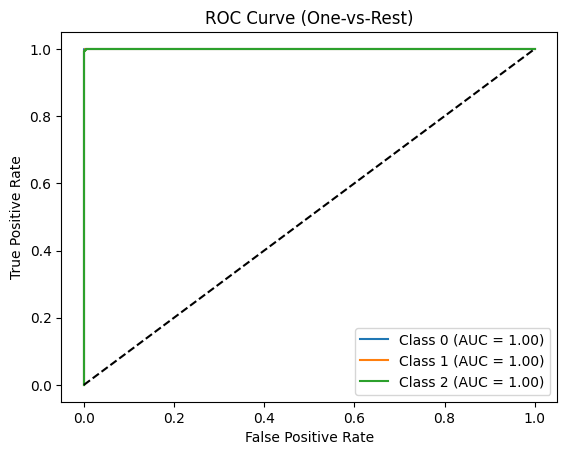

In [47]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import numpy as np

# Binarize the output
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Predict probabilities
y_score = grid.predict_proba(X_test)

# Plot ROC curve for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


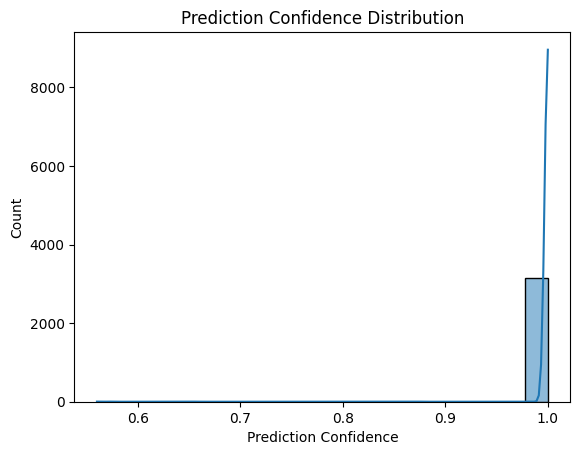

In [48]:
import seaborn as sns

# Get max probability per prediction
y_prob = grid.predict_proba(X_test)
confidence = y_prob.max(axis=1)

sns.histplot(confidence, bins=20, kde=True)
plt.title('Prediction Confidence Distribution')
plt.xlabel('Prediction Confidence')
plt.ylabel('Count')
plt.show()


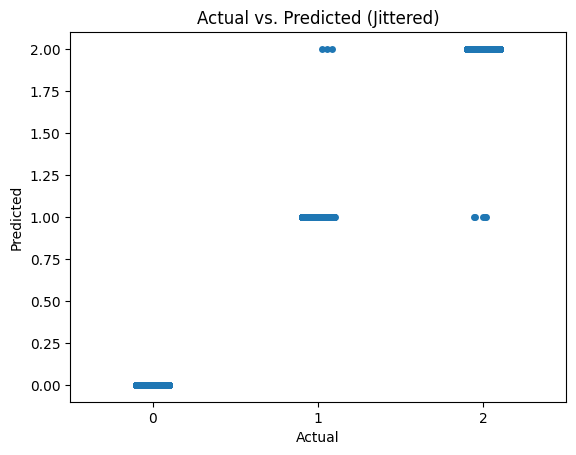

In [49]:
import pandas as pd
import seaborn as sns

df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': grid.predict(X_test)})
sns.stripplot(data=df_pred, x='Actual', y='Predicted', jitter=True)
plt.title('Actual vs. Predicted (Jittered)')
plt.show()
